# Task 1.1: Sensor Inventory

**Description**: Document all traffic counters/sensors with metadata

**Acceptance Criteria**: 
- Notebook with sensor locations, types, data availability periods
- Extract sensor metadata from traffic data
- Visualize sensor distribution
- Save sensor inventory for downstream use

**Output**: Sensor inventory DataFrame with metadata

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import json
from pathlib import Path

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 120)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"Notebook initialized at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Notebook initialized at 2025-09-06 12:02:10


## 1. Load Traffic Data Sources

In [2]:
# Define data paths
DATA_DIR = Path('/home/niko/workspace/slovenia-traffic/data')

# Load vehicle speed data
speed_file = DATA_DIR / 'production_merged_vehicle_speed.csv'
print(f"Loading speed data from: {speed_file}")
df_speed = pd.read_csv(speed_file, parse_dates=['datetime'])
print(f"Speed data shape: {df_speed.shape}")
print(f"Speed data columns: {list(df_speed.columns)}\n")

# Load vehicle count data
count_file = DATA_DIR / 'production_merged_vehicle_count.csv'
print(f"Loading count data from: {count_file}")
df_count = pd.read_csv(count_file, parse_dates=['datetime'])
print(f"Count data shape: {df_count.shape}")
print(f"Count data columns: {list(df_count.columns)}")

Loading speed data from: /home/niko/workspace/slovenia-traffic/data/production_merged_vehicle_speed.csv
Speed data shape: (1183248, 14)
Speed data columns: ['road_name', 'road_code', 'date', 'Time', 'direction_A_name', 'direction_B_name', 'Speed_Lane_1', 'Speed_Lane_2', 'Speed_Lane_3', 'Avg_Speed', 'Min_Speed', 'Max_Speed', 'StdDev_Speed', 'datetime']

Loading count data from: /home/niko/workspace/slovenia-traffic/data/production_merged_vehicle_count.csv
Count data shape: (876480, 19)
Count data columns: ['road_name', 'road_code', 'date', 'Time', 'direction_A_name', 'direction_B_name', 'direction_A_count', 'direction_B_count', 'Lane_1', 'Lane_2', 'Lane_3', 'Total_All_Lanes', 'Vignette_1', 'Vignette_2', 'Toll_1', 'Toll_2', 'Toll_3', 'Trucks_7.5t', 'datetime']


## 2. Extract Unique Sensors

In [3]:
# Extract unique sensors from speed data
# Each road_code represents a sensor location
speed_sensors = df_speed[['road_code', 'road_name', 'direction_A_name', 'direction_B_name']].drop_duplicates()
speed_sensors['sensor_type'] = 'speed'
speed_sensors.columns = ['sensor_id', 'location_name', 'direction_A', 'direction_B', 'sensor_type']

print(f"Unique speed sensors: {len(speed_sensors)}")
print("\nSample speed sensors:")
print(speed_sensors.head())

Unique speed sensors: 21

Sample speed sensors:
       sensor_id   location_name        direction_A        direction_B sensor_type
0           0011      Bertoki HC    Bertoki → Koper    Koper → Bertoki       speed
43824      0015a      Maribor HC   Center → Pesnica   Pesnica → Center       speed
87648      0015b      Maribor HC  Center → Slivnica  Slivnica → Center       speed
131472     0016a      Maliska HC   Maliska → Center   Center → Maliska       speed
175296      0021  Ljubljana Ring          Clockwise  Counter-clockwise       speed


In [4]:
# Extract unique sensors from count data
count_sensors = df_count[['road_code', 'road_name', 'direction_A_name', 'direction_B_name']].drop_duplicates()
count_sensors['sensor_type'] = 'count'
count_sensors.columns = ['sensor_id', 'location_name', 'direction_A', 'direction_B', 'sensor_type']

print(f"Unique count sensors: {len(count_sensors)}")
print("\nSample count sensors:")
print(count_sensors.head())

Unique count sensors: 22

Sample count sensors:
       sensor_id location_name        direction_A        direction_B sensor_type
0             11    Bertoki HC    Bertoki → Koper    Koper → Bertoki       count
32768       0011    Bertoki HC    Bertoki → Koper    Koper → Bertoki       count
43824      0015a    Maribor HC   Center → Pesnica   Pesnica → Center       count
87648      0015b    Maribor HC  Center → Slivnica  Slivnica → Center       count
131472     0016a    Maliska HC   Maliska → Center   Center → Maliska       count


In [5]:
# Combine all sensors
all_sensors = pd.concat([speed_sensors, count_sensors], ignore_index=True)

# Check for sensors that measure both speed and count
sensor_types = all_sensors.groupby('sensor_id')['sensor_type'].apply(lambda x: ','.join(sorted(x.unique()))).reset_index()
sensor_types.columns = ['sensor_id', 'capabilities']

# Merge back with sensor info
sensors_unique = all_sensors.drop_duplicates(subset=['sensor_id'])[['sensor_id', 'location_name', 'direction_A', 'direction_B']]
sensor_inventory = sensors_unique.merge(sensor_types, on='sensor_id')

print(f"Total unique sensors: {len(sensor_inventory)}")
print(f"\nSensor capabilities distribution:")
print(sensor_inventory['capabilities'].value_counts())

Total unique sensors: 22

Sensor capabilities distribution:
capabilities
count,speed    21
count           1
Name: count, dtype: int64


## 3. Calculate Data Availability Periods

In [6]:
# Calculate data availability for speed sensors
speed_availability = df_speed.groupby('road_code')['datetime'].agg([
    ('first_record', 'min'),
    ('last_record', 'max'),
    ('total_records', 'count')
]).reset_index()
speed_availability.columns = ['sensor_id', 'speed_first_record', 'speed_last_record', 'speed_total_records']

print("Speed sensor availability summary:")
print(speed_availability.describe())

Speed sensor availability summary:
                  speed_first_record    speed_last_record  speed_total_records
count                             21                   21            21.000000
mean   2020-10-11 06:51:25.714285824  2025-07-16 07:00:00         56345.142857
min              2020-08-30 00:00:00  2023-02-03 23:00:00         21312.000000
25%              2020-08-30 00:00:00  2025-08-29 23:00:00         43824.000000
50%              2020-08-30 00:00:00  2025-08-29 23:00:00         43824.000000
75%              2020-08-30 00:00:00  2025-08-29 23:00:00         43824.000000
max              2023-02-04 00:00:00  2025-08-29 23:00:00        350592.000000
std                              NaN                  NaN         67740.400768


In [7]:
# Calculate data availability for count sensors
count_availability = df_count.groupby('road_code')['datetime'].agg([
    ('first_record', 'min'),
    ('last_record', 'max'),
    ('total_records', 'count')
]).reset_index()
count_availability.columns = ['sensor_id', 'count_first_record', 'count_last_record', 'count_total_records']

print("Count sensor availability summary:")
print(count_availability.describe())

Count sensor availability summary:
                  count_first_record              count_last_record  count_total_records
count                             22                             22            22.000000
mean   2020-12-10 10:10:54.545454592  2025-06-27 09:10:54.545454592         39840.000000
min              2020-08-30 00:00:00            2023-02-03 23:00:00         11056.000000
25%              2020-08-30 00:00:00            2025-08-29 23:00:00         43824.000000
50%              2020-08-30 00:00:00            2025-08-29 23:00:00         43824.000000
75%              2020-08-30 00:00:00            2025-08-29 23:00:00         43824.000000
max              2024-05-26 08:00:00            2025-08-29 23:00:00         43824.000000
std                              NaN                            NaN          9278.184387


In [8]:
# Merge availability data with sensor inventory
sensor_inventory = sensor_inventory.merge(speed_availability, on='sensor_id', how='left')
sensor_inventory = sensor_inventory.merge(count_availability, on='sensor_id', how='left')

# Calculate overall availability
sensor_inventory['first_record'] = sensor_inventory[['speed_first_record', 'count_first_record']].min(axis=1)
sensor_inventory['last_record'] = sensor_inventory[['speed_last_record', 'count_last_record']].max(axis=1)
sensor_inventory['total_days'] = (sensor_inventory['last_record'] - sensor_inventory['first_record']).dt.days
sensor_inventory['total_records'] = sensor_inventory[['speed_total_records', 'count_total_records']].sum(axis=1)

print(f"Sensor inventory shape: {sensor_inventory.shape}")
print("\nSample sensor inventory:")
print(sensor_inventory.head())

Sensor inventory shape: (22, 15)

Sample sensor inventory:
  sensor_id   location_name        direction_A        direction_B capabilities speed_first_record   speed_last_record  \
0      0011      Bertoki HC    Bertoki → Koper    Koper → Bertoki  count,speed         2020-08-30 2025-08-29 23:00:00   
1     0015a      Maribor HC   Center → Pesnica   Pesnica → Center  count,speed         2020-08-30 2025-08-29 23:00:00   
2     0015b      Maribor HC  Center → Slivnica  Slivnica → Center  count,speed         2020-08-30 2025-08-29 23:00:00   
3     0016a      Maliska HC   Maliska → Center   Center → Maliska  count,speed         2020-08-30 2025-08-29 23:00:00   
4      0021  Ljubljana Ring          Clockwise  Counter-clockwise  count,speed         2020-08-30 2023-02-03 23:00:00   

   speed_total_records  count_first_record   count_last_record  count_total_records first_record         last_record  \
0              43824.0 2024-05-26 08:00:00 2025-08-29 23:00:00                11056   2020-08-

## 4. Analyze Sensor Characteristics

In [9]:
# Add sensor characteristics
sensor_inventory['has_speed'] = sensor_inventory['capabilities'].str.contains('speed')
sensor_inventory['has_count'] = sensor_inventory['capabilities'].str.contains('count')
sensor_inventory['is_dual'] = sensor_inventory['capabilities'] == 'count,speed'

# Calculate data quality metrics (assuming hourly data)
sensor_inventory['speed_coverage'] = sensor_inventory['speed_total_records'] / ((sensor_inventory['total_days'] + 1) * 24) * 100
sensor_inventory['count_coverage'] = sensor_inventory['count_total_records'] / ((sensor_inventory['total_days'] + 1) * 24) * 100
sensor_inventory['overall_coverage'] = sensor_inventory['total_records'] / ((sensor_inventory['total_days'] + 1) * 24) * 100

# Classify sensor quality
def classify_quality(coverage):
    if pd.isna(coverage):
        return 'No Data'
    elif coverage >= 80:
        return 'Excellent'
    elif coverage >= 60:
        return 'Good'
    elif coverage >= 40:
        return 'Fair'
    else:
        return 'Poor'

sensor_inventory['quality_category'] = sensor_inventory['overall_coverage'].apply(classify_quality)

print("Sensor quality distribution:")
print(sensor_inventory['quality_category'].value_counts())
print(f"\nAverage coverage: {sensor_inventory['overall_coverage'].mean():.2f}%")

Sensor quality distribution:
quality_category
Excellent    22
Name: count, dtype: int64

Average coverage: 223.87%


## 5. Visualize Sensor Distribution

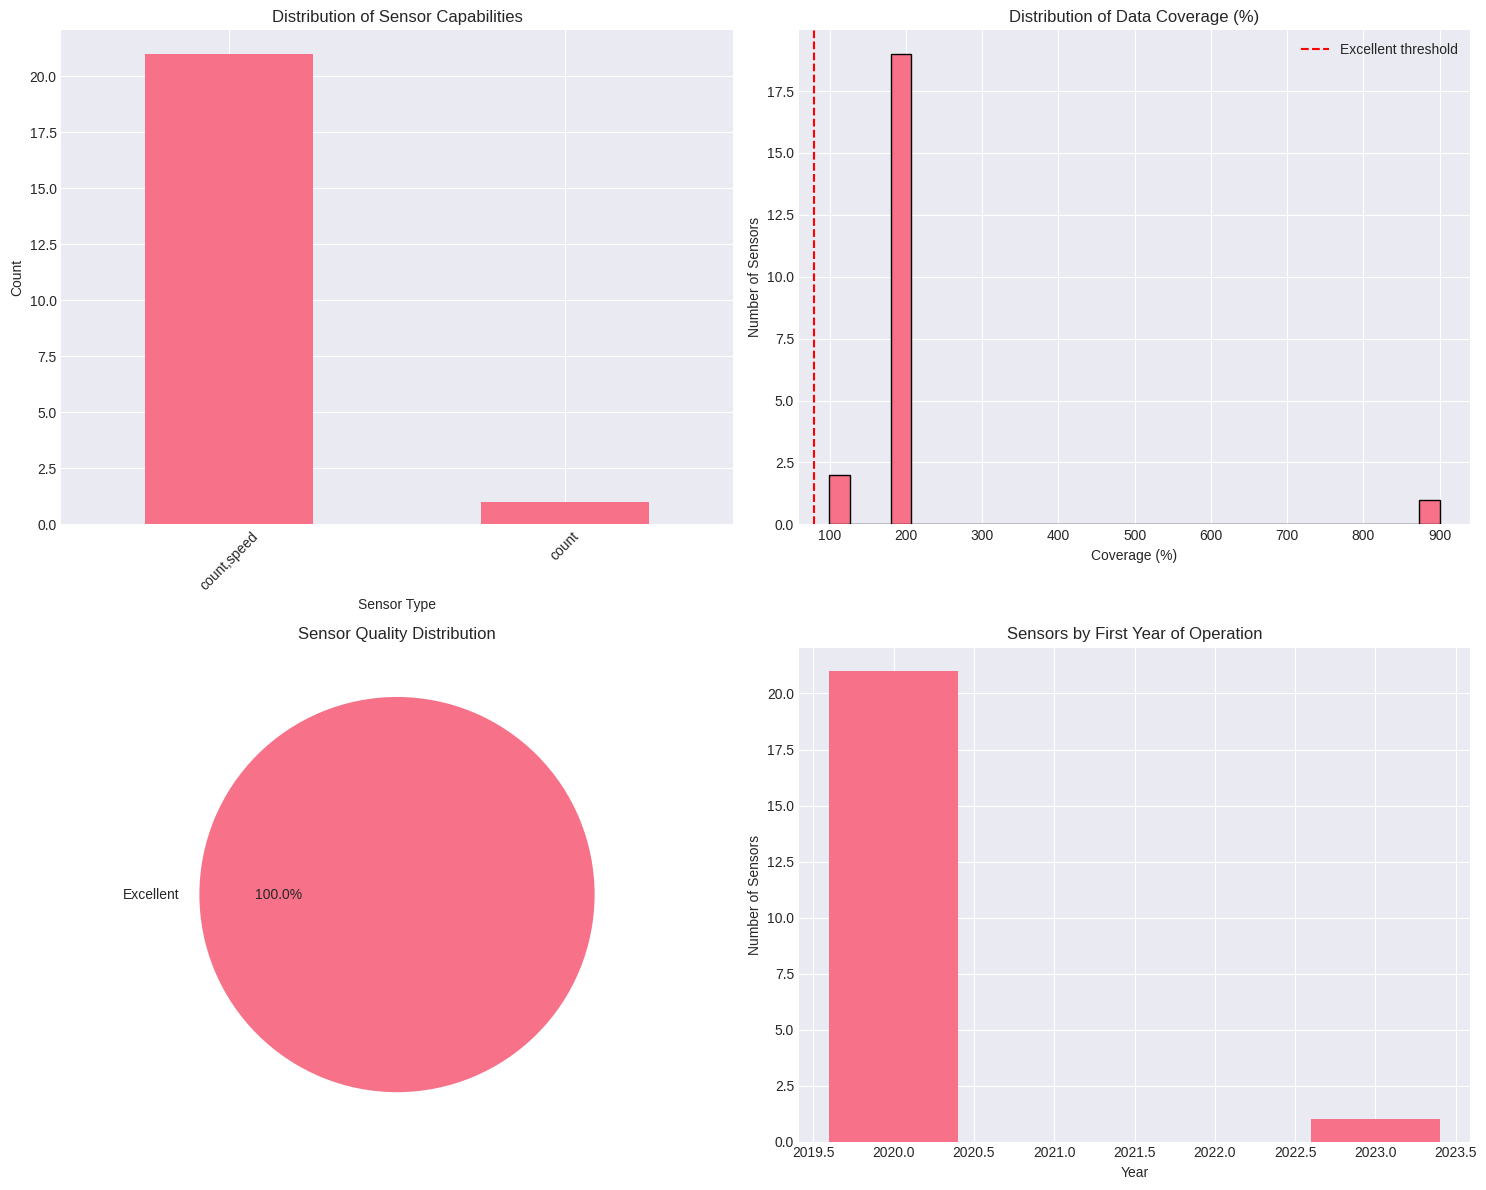

Visualization complete.


In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sensor types distribution
sensor_inventory['capabilities'].value_counts().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Sensor Capabilities')
axes[0, 0].set_xlabel('Sensor Type')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Data coverage distribution
coverage_data = sensor_inventory['overall_coverage'].dropna()
if len(coverage_data) > 0:
    axes[0, 1].hist(coverage_data, bins=30, edgecolor='black')
    axes[0, 1].set_title('Distribution of Data Coverage (%)')
    axes[0, 1].set_xlabel('Coverage (%)')
    axes[0, 1].set_ylabel('Number of Sensors')
    axes[0, 1].axvline(x=80, color='r', linestyle='--', label='Excellent threshold')
    axes[0, 1].legend()

# 3. Quality category pie chart
quality_counts = sensor_inventory['quality_category'].value_counts()
axes[1, 0].pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%')
axes[1, 0].set_title('Sensor Quality Distribution')

# 4. Records over time
sensor_inventory['year'] = pd.to_datetime(sensor_inventory['first_record']).dt.year
yearly_sensors = sensor_inventory.groupby('year').size()
if len(yearly_sensors) > 0:
    axes[1, 1].bar(yearly_sensors.index, yearly_sensors.values)
    axes[1, 1].set_title('Sensors by First Year of Operation')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Number of Sensors')

plt.tight_layout()
plt.show()

print("Visualization complete.")

## 6. Analyze Road Segments

In [11]:
# Analyze road segments and directions
print("=" * 80)
print("ROAD SEGMENT ANALYSIS")
print("=" * 80)

# Count unique directions
unique_directions_A = sensor_inventory['direction_A'].nunique()
unique_directions_B = sensor_inventory['direction_B'].nunique()

print(f"\nUnique Direction A values: {unique_directions_A}")
print(f"Unique Direction B values: {unique_directions_B}")

# Sample of direction pairs
print("\nSample Direction Pairs:")
direction_pairs = sensor_inventory[['location_name', 'direction_A', 'direction_B']].drop_duplicates().head(10)
print(direction_pairs.to_string(index=False))

ROAD SEGMENT ANALYSIS

Unique Direction A values: 20
Unique Direction B values: 20

Sample Direction Pairs:
  location_name       direction_A       direction_B
     Bertoki HC   Bertoki → Koper   Koper → Bertoki
     Maribor HC  Center → Pesnica  Pesnica → Center
     Maribor HC Center → Slivnica Slivnica → Center
     Maliska HC  Maliska → Center  Center → Maliska
 Ljubljana Ring         Clockwise Counter-clockwise
Koper-Ljubljana Koper → Ljubljana Ljubljana → Koper
  Celje-Maribor   Celje → Maribor   Maribor → Celje
Ljubljana-Celje Ljubljana → Celje Celje → Ljubljana
   Maribor-Ptuj    Maribor → Ptuj    Ptuj → Maribor
Ljubljana-Kranj Ljubljana → Kranj Kranj → Ljubljana


## 7. Statistical Summary

In [12]:
# Generate comprehensive statistics
print("=" * 80)
print("SENSOR INVENTORY SUMMARY")
print("=" * 80)

print(f"\nTotal Sensors: {len(sensor_inventory)}")
print(f"Speed Sensors: {sensor_inventory['has_speed'].sum()}")
print(f"Count Sensors: {sensor_inventory['has_count'].sum()}")
print(f"Dual Sensors: {sensor_inventory['is_dual'].sum()}")

print("\n" + "=" * 40)
print("DATA AVAILABILITY")
print("=" * 40)

print(f"\nEarliest Record: {sensor_inventory['first_record'].min()}")
print(f"Latest Record: {sensor_inventory['last_record'].max()}")
print(f"Average Days of Data: {sensor_inventory['total_days'].mean():.0f}")
print(f"Total Records: {sensor_inventory['total_records'].sum():,.0f}")

print("\n" + "=" * 40)
print("DATA QUALITY")
print("=" * 40)

quality_stats = sensor_inventory.groupby('quality_category').agg({
    'sensor_id': 'count',
    'overall_coverage': 'mean'
}).round(2)
quality_stats.columns = ['Count', 'Avg Coverage (%)']
print("\n", quality_stats)

print("\n" + "=" * 40)
print("TOP 10 SENSORS BY COVERAGE")
print("=" * 40)

top_sensors = sensor_inventory.nlargest(10, 'overall_coverage')[[
    'sensor_id', 'location_name', 'capabilities', 'overall_coverage', 'total_records'
]]
print("\n", top_sensors.to_string(index=False))

SENSOR INVENTORY SUMMARY

Total Sensors: 22
Speed Sensors: 21
Count Sensors: 22
Dual Sensors: 21

DATA AVAILABILITY

Earliest Record: 2020-08-30 00:00:00
Latest Record: 2025-08-29 23:00:00
Average Days of Data: 1721
Total Records: 2,059,728

DATA QUALITY

                   Count  Avg Coverage (%)
quality_category                         
Excellent            22            223.87

TOP 10 SENSORS BY COVERAGE

 sensor_id   location_name capabilities  overall_coverage  total_records
       31 Koper-Ljubljana  count,speed             900.0       394416.0
    0015a      Maribor HC  count,speed             200.0        87648.0
    0015b      Maribor HC  count,speed             200.0        87648.0
    0016a      Maliska HC  count,speed             200.0        87648.0
     0021  Ljubljana Ring  count,speed             200.0        42624.0
       21  Ljubljana Ring  count,speed             200.0        45024.0
       41   Celje-Maribor  count,speed             200.0        87648.0
       51 L

## 8. Save Sensor Inventory

In [13]:
# Prepare final sensor inventory for export
sensor_inventory_export = sensor_inventory[[
    'sensor_id', 'location_name', 'direction_A', 'direction_B',
    'capabilities', 'has_speed', 'has_count', 'is_dual',
    'first_record', 'last_record', 'total_days', 'total_records',
    'speed_total_records', 'count_total_records',
    'overall_coverage', 'quality_category'
]]

# Save to multiple formats
output_dir = DATA_DIR / 'processed'
output_dir.mkdir(exist_ok=True)

# Save as CSV
csv_file = output_dir / 'sensor_inventory.csv'
sensor_inventory_export.to_csv(csv_file, index=False)
print(f"Saved CSV: {csv_file}")

# Save summary statistics as JSON
summary_stats = {
    'total_sensors': len(sensor_inventory),
    'speed_sensors': int(sensor_inventory['has_speed'].sum()),
    'count_sensors': int(sensor_inventory['has_count'].sum()),
    'dual_sensors': int(sensor_inventory['is_dual'].sum()),
    'earliest_record': str(sensor_inventory['first_record'].min()),
    'latest_record': str(sensor_inventory['last_record'].max()),
    'average_days': float(sensor_inventory['total_days'].mean()) if not sensor_inventory['total_days'].isna().all() else 0,
    'total_records': int(sensor_inventory['total_records'].sum()),
    'quality_distribution': sensor_inventory['quality_category'].value_counts().to_dict(),
    'average_coverage': float(sensor_inventory['overall_coverage'].mean()) if not sensor_inventory['overall_coverage'].isna().all() else 0
}

json_file = output_dir / 'sensor_inventory_summary.json'
with open(json_file, 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)
print(f"Saved JSON summary: {json_file}")

print("Sensor inventory successfully created and saved!")

Saved CSV: /home/niko/workspace/slovenia-traffic/data/processed/sensor_inventory.csv
Saved JSON summary: /home/niko/workspace/slovenia-traffic/data/processed/sensor_inventory_summary.json
Sensor inventory successfully created and saved!


## Summary

This notebook successfully completed Task 1.1 by:

1. **Loading** traffic data from speed and count sensors
2. **Identifying** all unique sensors and their capabilities
3. **Calculating** data availability periods and quality metrics
4. **Visualizing** sensor distribution statistically
5. **Saving** the sensor inventory in multiple formats for downstream use

The sensor inventory is now available for the next tasks in the pipeline.